# Class Activity 6: Quiz [10 minutes]

1. What's the difference between these two specifications?

\begin{align*}
\mathbf{y}_{n\times 1} \sim {} & \mathcal{MVN}(\mathbf{X}_{n\times p}\boldsymbol{\beta}_{p\times 1},\boldsymbol \Sigma_{n\times n} = \sigma^2I_{n\times n}) \\\\\hline\\
\mathbf{y}_{i} \sim {} & \mathcal{MVN}(\boldsymbol \mu,\boldsymbol \Sigma = \mathbf{DRD})\\
p(\mathbf{y}|\boldsymbol \beta, \sigma, \mathbf{X}) = {}& (2\pi )^{-n/2}{\det({\boldsymbol {\Sigma }})^{-1/2}}\exp \left(-{\frac {1}{2}}(\mathbf {y} - \boldsymbol\mu)^\top{\boldsymbol {\Sigma }^{-1}}(\mathbf {y} - \boldsymbol\mu)\right)
\end{align*}

2. How should the latter be changed to create ***multivariate linear regression*** (as opposed to just ***linear regression***)?

3. Specify a ***multivariate generalized linear regression*** whose ***marginal distributions*** are each univariate ***logistic regressions*** but which also provides a ***parameterization*** of the ***joint dependency*** structure between the ***marginal outcomes***


# Class Activity 6: Solutions [10 minutes]

1. The first is ***linear regression model*** where the features $\mathbf{X}$ are used to predict outcomes $\mathbf{y}$; whereas, the second is simply a ***multivariate normal model***.

2. Each element $\mu_k = x^T_i \boldsymbol \beta^{(k)}$ of $\boldsymbol \mu$ becomes a ***linear model*** and then the ***covariance matrix*** $\boldsymbol \Sigma$ captures the residual dependence in the ***residual multivariate outcome*** $(\mathbf{y}_i -\boldsymbol \mu)$

3. ***Generalized Multivariate Linear Models (GLM) using probit link functions***

   The ***probit link function*** $Pr(y_i=1|\mathbf{x}) = \frac{1}{1+e^{-\mathbf x_i^\top \boldsymbol \beta}}$ could be applied to the ***marginal outcomes*** of $\mathbf{y}_{i} \sim \mathcal{MVN}(\boldsymbol \mu,\boldsymbol \Sigma = \mathbf{DRD})$ which would then subequently be used as the ***mean parameter*** of a ***Binomial distribution***; however, an alternative specification often preferred in ***Bayesian*** contexts would be to use the ***probit link function*** $Pr(y_i=1|\mathbf{x}) = \Phi(\mu_i)$ where $\Phi$ is the ***CDF*** of a ***standard normal distribution***
   
   - The transformation of the ***marginal distributions*** of a ***multivariate normal random variable*** into other ***distributional forms*** (such as ***Binomial distributions*** as done here) is the core principle behind ***copula*** methodologies. 


# Homework 6: Part I

1. Go get data from kaggle.com and do a ***(Univariate) Bayesian Logistic Regression*** analysis

2. Adjust the code below to specify that the outcomes have a Bernoulli distribution and use a ***probit*** or ***logit*** to correctly paramterize the predicted values of the observed outcomes 

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

3. Choose ***prior*** that are sensible for your specification 

4. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Go get data from kaggle.com and do a ***Multivariate Bayesian Logistic Regression*** analysis


# Bayesian Multiplicity Adjustment:<br>Significance Dichotomy [7 minutes]

***Hypothesis testing*** involves a mixture of ***effect sizes***, some large and some negligable

This can coarsely be viewed as the dichotomy of ***significant*** versus ***insignificant tests***


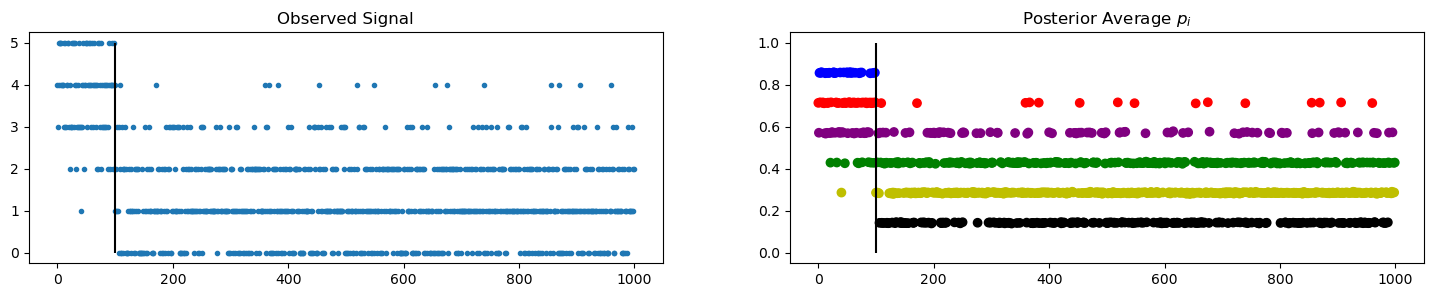

In [271]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2,figsize=(18,3))
# first 100 are "interesting" (high p) distributions; but the (posterior p) "evidence" depends only on observed outcome
np.random.seed(1); y_obs = np.r_[stats.binom(p=0.75,n=5).rvs(100),stats.binom(p=0.25,n=5).rvs(900)]; ax[0].plot(y_obs,'.'); ax[0].set_title('Observed Signal'); ax[0].vlines(100,ymin=0,ymax=5,color='k'); ax[1].scatter(np.arange(1000), idata.posterior['p'].values.reshape((-1,1000)).mean(axis=0),c=[['k','y','g','purple','r','b'][c] for c in y_obs]); ax[1].set_title('Posterior Average $p_i$'); ax[1].vlines(100,ymin=0,ymax=1,color='k'); 

In [237]:
import pymc as pm
with pm.Model() as no_multiplicity_correction:
    p = pm.Beta('p', alpha=1, beta=1, shape=1000)
    y = pm.Binomial('y', n=5, p=p, observed=y_obs)
with no_multiplicity_correction:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


# Bayesian Multiplicity Adjustment:<br>Hierarchical Modeling [10 minutes]

$$\require{cancel}
\begin{align*}
\cancel{p_i} \sim {}& \cancel{\text{beta}(\alpha, \beta)} & p \sim {}& \text{beta}(\alpha, \beta) \quad  x_i \sim \text{Bernoulli}(p) & p_0 \sim {}& \text{beta}(\alpha_0, \beta_0) \\
\cancel{y_i} \sim {} & \cancel{\text{binomial}(p,n)} & y_i \sim {} & \text{binomial}(\underbrace{p_0+x_ip_1}_{\text{restrict to } [0,1]},n) & p_1 \sim{}& \text{beta}(\alpha_1, \beta_1)
\end{align*}$$



In [280]:
with pm.Model() as multiplicity_correction:
    p = pm.Beta('p', alpha=1, beta=1)
    x = pm.Binomial('x', n=1, p=p, shape=1000)
    p0 = pm.Beta('p0', alpha=1, beta=1)
    p1 = pm.Beta('p1', alpha=1, beta=1)
    no_negatives = pm.math.switch(pm.math.lt(p0+x*p1,0), 0, p0+x*p1)
    in_unit_interval = pm.math.switch(pm.math.gt(no_negatives,1), 1, p0+x*p1)
    p01 = pm.Deterministic('p01', in_unit_interval)
    y = pm.Binomial('y', n=5, p=p01, observed=y_obs) # p=0.25+x*0.5
    
with multiplicity_correction:
    idata2 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, p0, p1]
>Metropolis: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Bayesian Multiplicity Adjustment:<br>Hierarchical Modeling [3 minutes]

$$\require{cancel}
\begin{align*}
\cancel{p_i} \sim {}& \cancel{\text{beta}(\alpha, \beta)} & p \sim {}& \text{beta}(\alpha, \beta) \quad  x_i \sim \text{Bernoulli}(p) & p_0 \sim {}& \text{beta}(\alpha_0, \beta_0) \\
\cancel{y_i} \sim {} & \cancel{\text{binomial}(p,n)} & y_i \sim {} & \text{binomial}(\underbrace{p_0+x_ip_1}_{\text{restrict to } [0,1]},n) & p_1 \sim{}& \text{beta}(\alpha_1, \beta_1)
\end{align*}$$


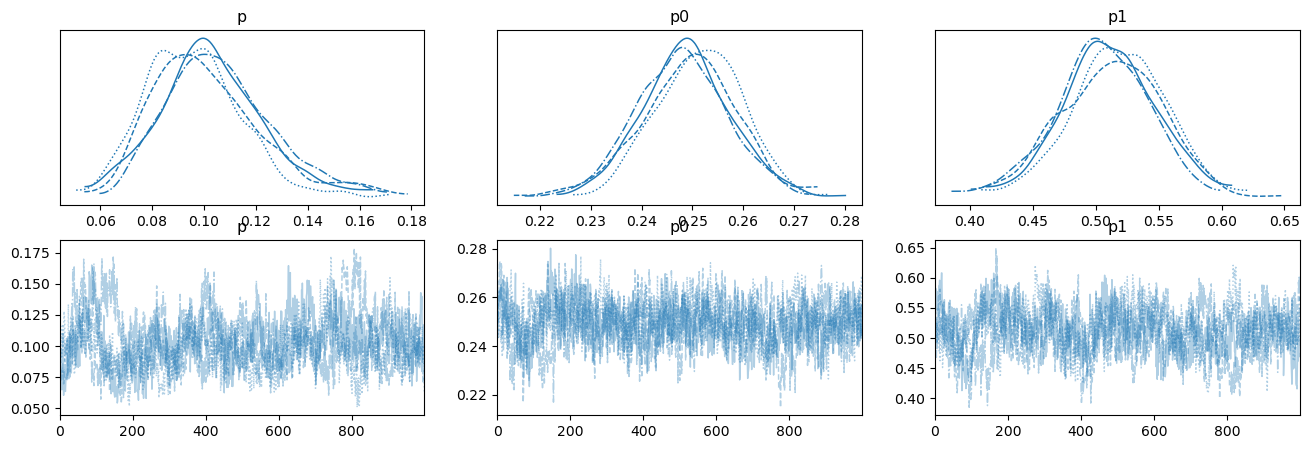

In [281]:
fig,ax = plt.subplots(2,3,figsize=(16,5))
import arviz as az; az.plot_trace(idata2, var_names=["p","p0","p1"], axes=ax.T); 

# Bayesian Multiplicity Adjustment: Hierarchical Modeling<br>and the Power of Information Sharing [10 minutes]

Learning the proportion of examples that are "interesting" actually means learning<br>WHICH examples are interesting by ***imputing*** weather or not each of the examples is interesting one or not


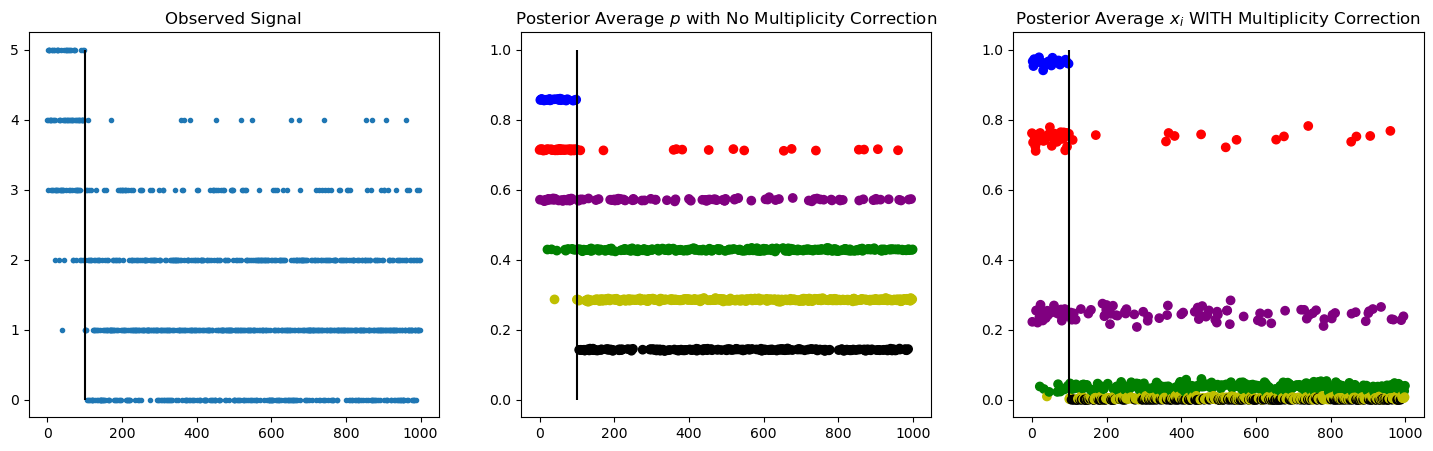

In [283]:
# first 100 are "interesting" (high p) distributions; but the (posterior p) "evidence" depends only on observed outcome
fig,ax = plt.subplots(1,3,figsize=(18,5)); np.random.seed(1); y_obs = np.r_[stats.binom(p=0.75,n=5).rvs(100),stats.binom(p=0.25,n=5).rvs(900)]; ax[0].plot(y_obs,'.'); ax[0].set_title('Observed Signal'); ax[0].vlines(100,ymin=0,ymax=5,color='k'); ax[1].scatter(np.arange(1000), idata.posterior['p'].values.reshape((-1,1000)).mean(axis=0),c=[['k','y','g','purple','r','b'][c] for c in y_obs]); ax[1].set_title('Posterior Average $p$ with No Multiplicity Correction'); ax[1].vlines(100,ymin=0,ymax=1,color='k'); ax[2].scatter(np.arange(1000), idata2.posterior['x'].values.reshape((-1,1000)).mean(axis=0),c=[['k','y','g','purple','r','b'][c] for c in y_obs]); ax[2].set_title('Posterior Average $x_i$ WITH Multiplicity Correction'); ax[2].vlines(100,ymin=0,ymax=1,color='k'); 

# Bayesian Variable Selection:<br>"Spike and Slab" [12 minutes]

\begin{align*}
p \sim {} & \text{beta}(\alpha,\beta) \\
s_i \sim {}& \text{Bernoulli}(p) & b_i \sim {} & \text{Normal}(\mu_0,\sigma_0) & \beta_i = {}& b_i\times s_i \\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}

In [285]:
m,q = 20,10; betas = np.zeros((m,1)); betas[0:q,0] = np.linspace(0,q-1,q); np.random.seed(2)
n = 100; X = stats.binom(n=1,p=0.5).rvs(size=(n,m)); y_obs=X.dot(betas).flatten() + stats.norm().rvs(size=n)

with pm.Model() as spikeNslab:
    p = pm.Beta('p', alpha=1, beta=1)
    spike = pm.Binomial('spike', n=1, p=p, shape=m)
    slab = pm.Normal('slab', mu=0, sigma=10, shape=m)
    beta = pm.Deterministic('beta', spike*slab) # elementwise multiplication
    sigma = pm.HalfNormal('sigma', sigma=2)
    y = pm.Normal('y', mu=pm.math.dot(X, beta), sigma=sigma, observed=y_obs)
    
with spikeNslab:
    idata3 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, slab, sigma]
>Metropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 815 divergences after tuning. Increase `target_accept` or reparameterize.


# Bayesian Variable Selection:<br>"Spike and Slab" [4 minutes]

\begin{align*}
p \sim {} & \text{beta}(\alpha,\beta) \\
s_i \sim {}& \text{Bernoulli}(p) & b_i \sim {} & \text{Normal}(\mu_0,\sigma_0) & \beta_i = {}& b_i\times s_i \\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}

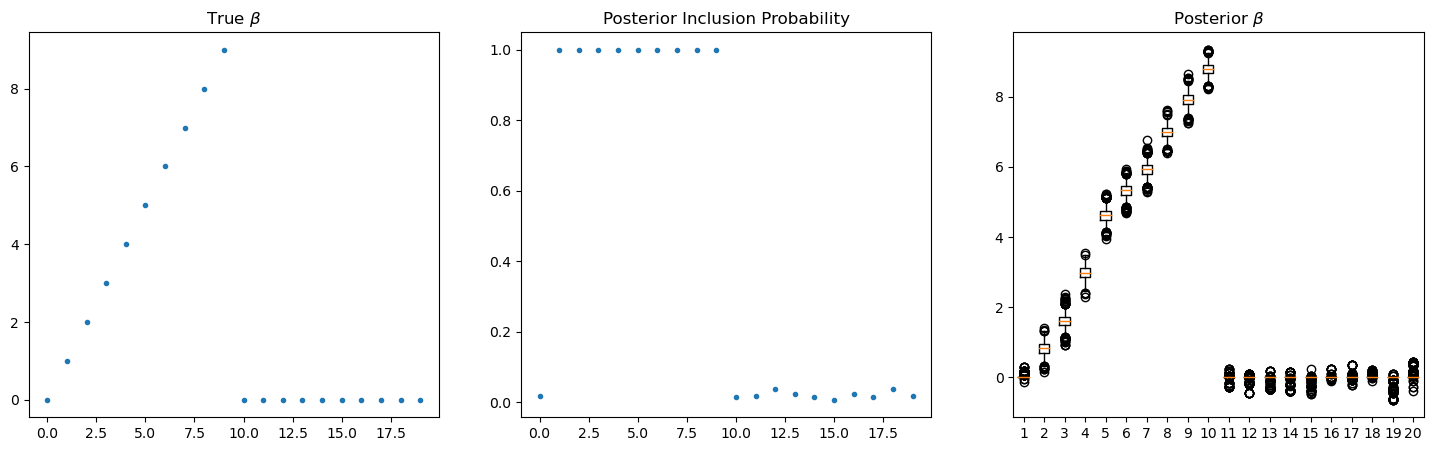

In [286]:
fig,ax = plt.subplots(1,3,figsize=(18,5)); ax[0].plot(betas,'.'); ax[0].set_title('True $\\beta$'); ax[1].plot(idata3.posterior['spike'].values.reshape((-1,m)).mean(axis=0),'.'); ax[1].set_title('Posterior Inclusion Probability'); ax[2].boxplot(idata3.posterior['beta'].values.reshape((-1,m))); ax[2].set_title('Posterior $\\beta$');

# Bayesian Variable Selection:<br>"Spike and Slab" [4 minutes]

\begin{align*}
p \sim {} & \text{beta}(\alpha,\beta) \\
s_i \sim {}& \text{Bernoulli}(p) & b_i \sim {} & \text{Normal}(\mu_0,\sigma_0) & \beta_i = {}& b_i\times s_i \\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}

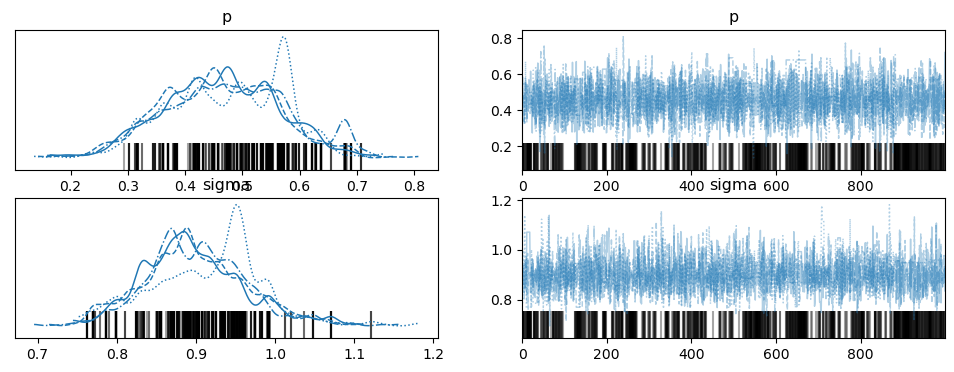

In [287]:
import arviz as az; az.plot_trace(idata3, var_names=["p","sigma"]); 

# Bayesian Shrinkage Estimation:<br>"Lasso Regression" [10 minutes]

***Ridge Regression*** ***$L_2$-penalty*** is just using ***norml priors*** for the ***regression coefficients***

\begin{align*}
 \beta_i \sim {} & \text{Normal}(b_i,s_i) & f(\beta_i| b_i, s_i) = {}& \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{\beta_i-b_i}{s_i}\right)^2} & \overbrace{\underbrace{|\beta_i-b_i|^2}}_{\text{Squared Penalization}}^{L_2} \\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0) 
\end{align*}

***Lasso Regression*** ***$L_1$-penalty*** is just replacing the ***norml priors*** with ***Laplace ("Double Exponential") prior distributions***

\begin{align*}
\beta_i \sim {} & \text{Laplace}(b_i,s_i) & f(\beta_i| b_i, s_i) = {}& {\frac  {1}{2b}}\exp \left(-{\frac{|\beta_i-b_i |}{s_i}}\right) & \overbrace{\underbrace{|\beta_i-b_i|}}_{\text{Absolute Penalization}}^{L_1}\\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}




# Bayesian Shrinkage Estimation: Geometrically [15 minutes]

ML thought they invented "regularization"... *Priors are Regularization!*<br>Bayes been regularizing since 1763: Bayesian analysis is the original regularization methodology


|![](https://miro.medium.com/v2/resize:fit:602/0*VMMQbv7-isMXB5Nk.png)|![](https://theoreticalecology.files.wordpress.com/2021/10/wics1463-toc-0001-m.jpg)|
|-|-|
|<img src="https://journals.sagepub.com/cms/10.1177/09622802221090752/asset/images/large/10.1177_09622802221090752-fig1.jpeg" style="width:600px"> | <img src="https://jrnold.github.io/bayesian_notes/regression-shrinkage_files/figure-html/unnamed-chunk-4-1.png" style="width:700px"> |





# Bayesian Shrinkage Estimation:<br>"Lasso Regression" [5 minutes]


In [403]:
m,q = 20,10; betas = np.zeros((m,1)); betas[0:q,0] = np.linspace(0,q-1,q); np.random.seed(2)
n = 30; X = stats.binom(n=1,p=0.5).rvs(size=(n,m)); y_obs=X.dot(betas).flatten() + stats.norm().rvs(size=n)
with pm.Model() as lasso:
    beta = pm.Laplace('beta', mu=0, b=10, shape=m); sigma = pm.HalfNormal('sigma', sigma=2)
    y = pm.Normal('y', mu=pm.math.dot(X, beta), sigma=sigma, observed=y_obs)
    idata4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


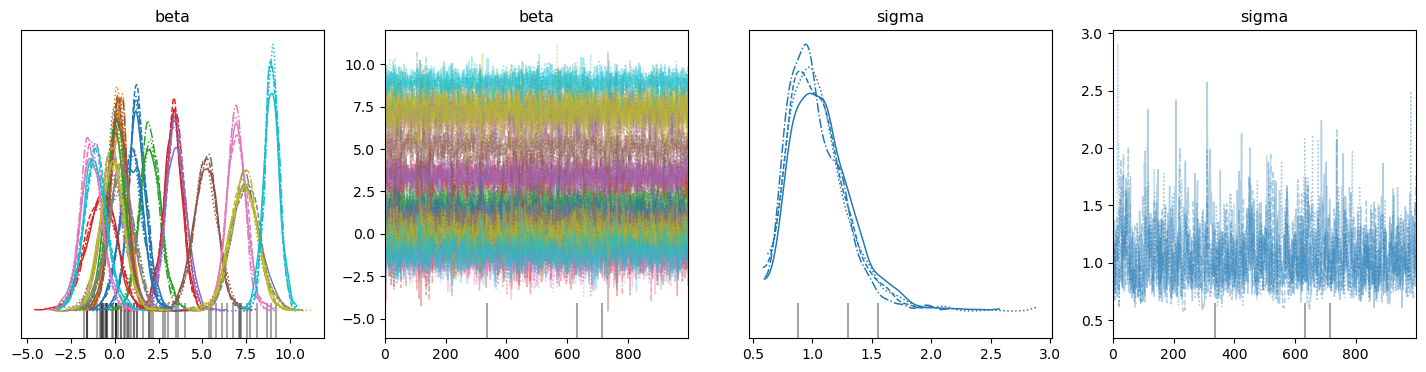

In [404]:
fig,ax = plt.subplots(1,4,figsize=(18,4)); az.plot_trace(idata4, axes=ax.reshape(2,2));

# Bayesian Shrinkage Estimation:<br>"Lasso Regression" [5 minutes]


In [415]:
with pm.Model() as lasso:
    beta = pm.Laplace('beta', mu=0, b=0.4, shape=m)
    sigma = pm.HalfNormal('sigma', sigma=2)
    y = pm.Normal('y', mu=pm.math.dot(X, beta), sigma=sigma, observed=y_obs)
    
with lasso:
    idata4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


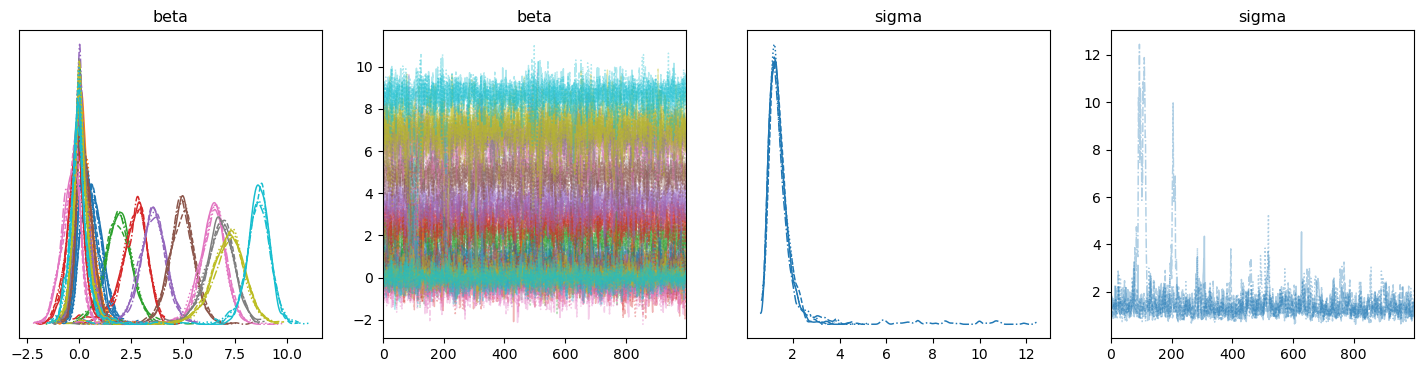

In [416]:
fig,ax = plt.subplots(1,4,figsize=(18,4)); az.plot_trace(idata4, axes=ax.reshape(2,2));

# Bayesian Shrinkage Estimation: "The Horseshoe" [15 minutes]

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) [other](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \beta) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \beta \left[1 + \left(\frac{x}{\beta}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{-2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



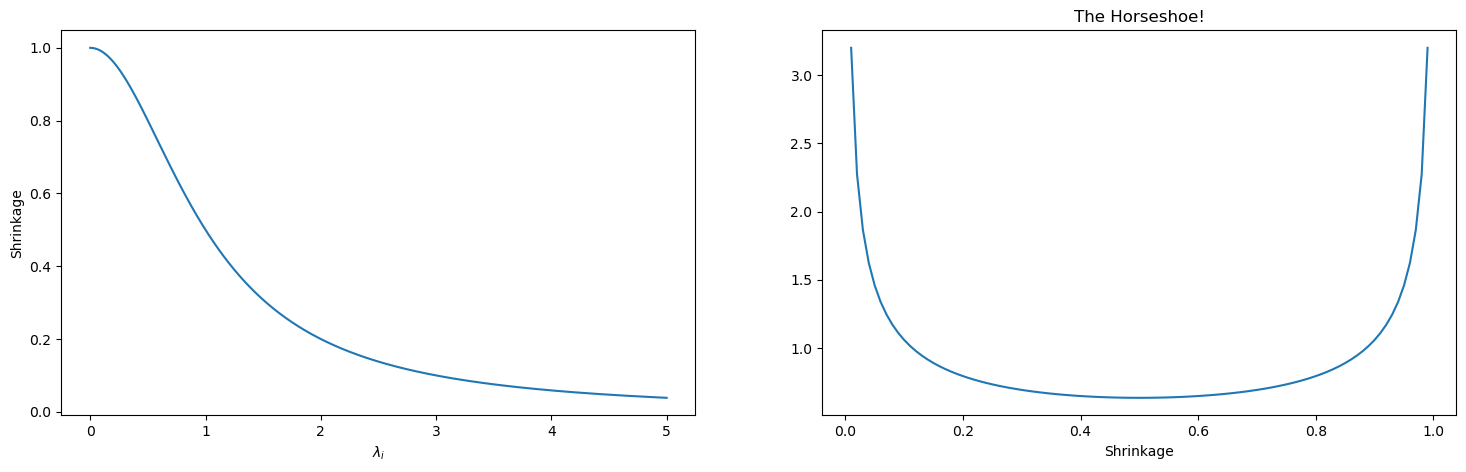

In [336]:
fig,ax = plt.subplots(1,2,figsize=(18,5)); support = np.linspace(0,5,1000); # shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2); ax[0].plot(support, shrinkage); ax[0].set_ylabel("Shrinkage"); ax[0].set_xlabel("$\\lambda_i$"); 
# change of variables: spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5; jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99); ax[1].plot(shrinkage, stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2)); ax[1].set_title('The Horseshoe!'); ax[1].set_xlabel("Shrinkage");

# Bayesian Shrinkage Estimation: "The Horseshoe" [15 minutes]


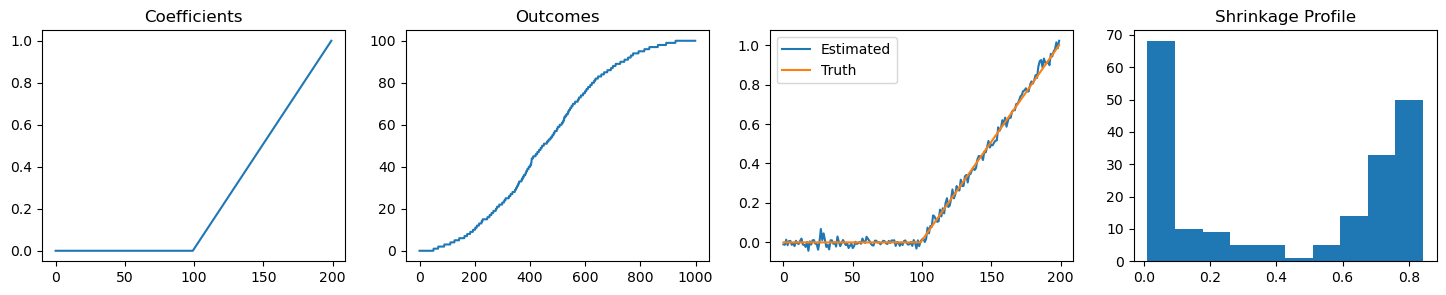

In [339]:
from scipy.special import expit as invlogit; fig,ax = plt.subplots(1,4,figsize=(18,3)); K,Q=100,100; w=np.arange(1,K+1)/K; w = np.concatenate([np.zeros((1,Q)), w[np.newaxis,:]], axis=1).flatten(); ax[0].plot(w); ax[0].set_title("Coefficients");
# nonzero and noise coefficients "weights" w (beta is reserved for the Half-Cauchy parameter below) 
P=1000; X=stats.bernoulli(p=0.5).rvs(size=(K+Q)*P).reshape(P,(K+Q)); N=100; THETA=-25; x=stats.binom(p=invlogit(THETA+X@w), n=[N]*P).rvs(); ax[1].plot(sorted(x)); ax[1].set_title("Outcomes"); 
ax[2].plot(posterior.posterior['weights'].values.reshape((-1,4000,200))[0,:,:].mean(axis=0), label='Estimated'); ax[2].plot(w, label='Truth'); ax[2].legend(); 
ax[3].hist(1/(1+posterior.posterior['lambdas'].values.reshape((-1,4000,200))[0,:,:].mean(axis=0)**2)); ax[3].set_title('Shrinkage Profile'); 

In [296]:
from pymc.math import invlogit as tt_invlogit
with pm.Model() as horseshoe:    
    tau_0 = 1; tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P, observed=x)
    posterior = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambdas, weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1448 divergences after tuning. Increase `target_accept` or reparameterize.


# Bayesian Shrinkage Estimation:<br>"Regularized Horseshoe" [10 minutes]

$$\kappa_j=\frac{1}{1+\lambda_j} \quad \text{ for } \tau=\beta=n=1 \quad \text{ generalizes too } \quad \frac{1}{1 + n \sigma^{-2}\tau^2 s_{x_j}^2 \lambda^2_j} = \underset{\text{if } Var(x_j) = s_{x_j}^2 = 1}{\frac{1}{1 + \frac{n}{ \beta^2}\tau^2 \lambda^2_j}}$$ 
The *smaller* $\frac{n}{\sigma^2}\tau^2$ is the *greater* the number of the $D$ parameters experiencing shrinkage [[1]](https://arxiv.org/pdf/1707.01694.pdf) [[2]](https://www.youtube.com/watch?v=EuhvfvY8ISc) [[3]](https://avehtari.github.io/modelselection/regularizedhorseshoe_slides.pdf)

- ***Hyperparameter*** $\tau_0$ drives the ***effective number of parameters*** $E\left[ \sum_{k=1}^D 1 - \kappa_j \right] = \frac{\frac{\tau_0}{\sigma}\sqrt{n}}{1+\frac{\tau_0}{\sigma}\sqrt{n}}D$ 

    - $\tau_0 = \frac{p_0}{D-p_0}\frac{\sigma}{\sqrt{n}}$ can be interpreted based on the number of "effectively non-zero" parameters $p_0$



In [344]:
import random; w_prime = w.copy(); w_prime[random.sample(range(len(w)), 150)] = 0 # zero out some coefficients
THETA = -6; x = stats.binom(p=invlogit(THETA+X@w_prime), n=[N]*P).rvs(); #plt.figure(figsize=(18,3)); plt.plot(sorted(x/N)); 
with pm.Model() as mod_reg_1p0:
    tau_0 = 1; tau = tau_0 #tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P, observed=x)
    posterior_reg_1p0 = pm.sample()    
with pm.Model() as mod_reg_0p01:
    tau_0 = 0.01; tau = tau_0 #tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P, observed=x)
    posterior_reg_0p01 = pm.sample()        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas, weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1083 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas, weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 488 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1638 divergences after tuning. Increase `target_accept` or reparameterize.


# Bayesian Shrinkage Estimation:<br>"Regularized Horseshoe" [5 minutes]


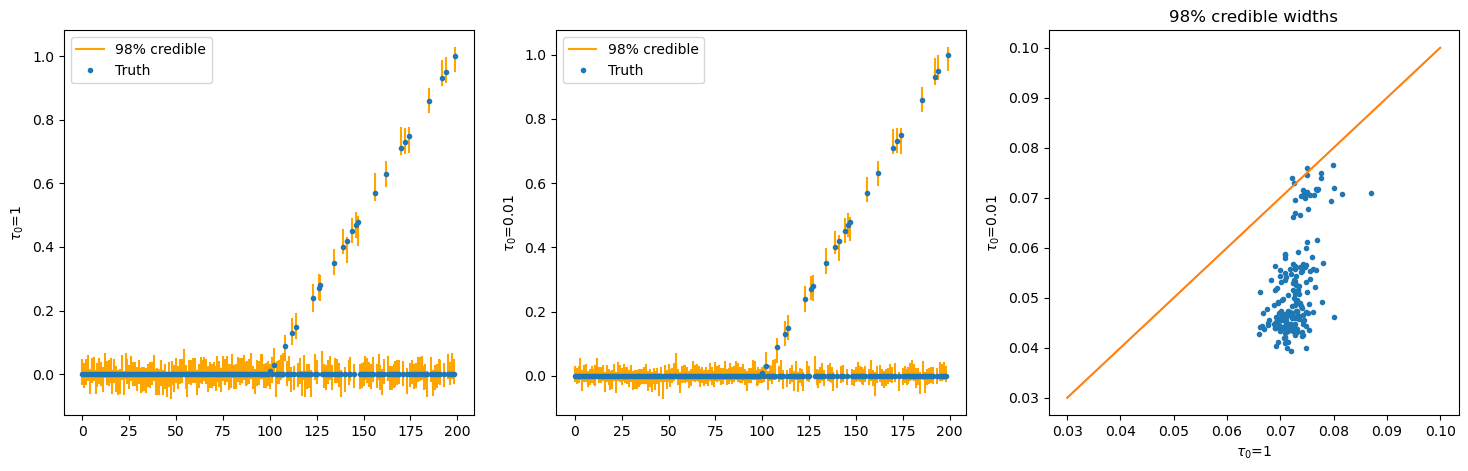

In [375]:
fix,ax = plt.subplots(1,3,figsize=(18,5)); par_1p0 = np.array(2*[np.arange(len(posterior_reg_1p0.posterior['weights'].values.reshape((-1,4000,200))[0].mean(axis=0)))]); val_1p0 = np.percentile(posterior_reg_1p0.posterior['weights'].values.reshape((-1,4000,200))[0], [1, 99], axis=0); ax[0].plot(par_1p0,val_1p0,'orange'); ax[0].plot(par_1p0[:,0],val_1p0[:,0],'orange', label='98% credible'); ax[0].plot(w_prime, '.', label='Truth'); ax[0].set_ylabel('$\\tau_0$=1'); ax[0].legend();  par_0p01 = np.array(2*[np.arange(len(posterior_reg_0p01.posterior['weights'].values.reshape((-1,4000,200))[0].mean(axis=0)))]); val_0p01 = np.percentile(posterior_reg_0p01.posterior['weights'].values.reshape((-1,4000,200))[0], [1, 99], axis=0); ax[1].plot(par_0p01,val_0p01,'orange'); ax[1].plot(par_0p01[:,0],val_0p01[:,0],'orange', label='98% credible'); ax[1].plot(w_prime, '.', label='Truth'); ax[1].set_ylabel('$\\tau_0$=0.01'); ax[1].legend(); ax[2].plot(val_1p0[1]-val_1p0[0],val_0p01[1]-val_0p01[0],'.'); ax[2].set_xlabel('$\\tau_0$=1'); ax[2].set_ylabel('$\\tau_0$=0.01'); plt.title('98% credible widths'); ax[2].plot([.03,.1],[.03,.1]); 

# Homework 6: Part II<br>Robust regression: [scale mixtures (of normals)](https://www.johndcook.com/t_normal_mixture.pdf)

$$\int \frac{w\lambda_i}{\sqrt{2\pi}}e^{-\frac{1}{2}\left(w^{-2}\lambda_i^{-2}(y_i-\mu)^2\right)} {\frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma (\frac{\nu}{2})}}\lambda_i^{\nu-\frac{1}{2}}e^{-\frac{\nu}{2}\lambda_i^{-2}} d\lambda_i = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma (\frac{\nu}{2})\sqrt{\pi \nu w^2}}\left(1 + \frac{1}{\nu}\left(\frac{y_i-\mu}{w}\right)^2 \right)^{-\frac{\nu+1}{2}}$$

$$\begin{array}{rcl}
y_i|\lambda_i & \sim & \mathcal{N}(X\beta, \sigma^2 = w^2 \lambda_i^2)\\
\lambda_i^{-2} & \sim & \text{Gamma}(\alpha=\nu/2, \beta=\nu/2)\end{array} \quad \Longrightarrow \quad y_i \sim t_\nu(\mu, w^2)$$

1. Return to your kaggle.com regression data set; or, find another data set; and use the above specification to perform a robust regression analysis in `PyMC`

2. Use the posterior distributions of the $\lambda_i$'s to identify "outlier" (and potentially "influential") data points

3. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)
4. [Optional] Perform ***Multiple Linear Regression*** diagnostics... residual plots, etc.


